In [157]:
clear all

In [158]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

In [159]:
from sklearn import linear_model

# Open data

In [160]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie2/100160/100160it30/100160Final/100160ss2cregcdFF20sMpsfkf250int179Smith0_4_60TS.mat


In [161]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(5527, 179)

In [162]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie2/100160/100160it30/100160Final/100160ss2cregcdFF20sMpsfkf250int179Smith0_4_60IC.nii


In [163]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(173, 110, 10, 179)

In [164]:
Time_fluoICA=np.array(range(5527))*0.01

Z-score

In [165]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [166]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [167]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-1.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

In [168]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie2/100160/100160it30/100160Final/100160Xk.mat


In [169]:
Ua=sio.loadmat(filename)
Xk=Ua['Xk']

In [170]:
Xk.shape

(5527, 8)

# Open Masks

In [171]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie2/100160/JFRC100160Transformedfullpsftrimmed.nii


In [172]:
Masks.shape

(173, 110, 10, 87)

In [173]:
filenameM='/home/sophie/Downloads/RegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.split('\t') for Line in content]
RegionName=[Names[i][0] for i in range(75)]
Num=[int(Names[i][2]) for i in range(75)]

# Average in masks to sort components by brain region

In [176]:
M=np.zeros((S[3],86))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(86)
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(86):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [178]:
S=M.shape
M2=np.zeros((S[0],75))
for j in range(86):
    J=np.array([l for l in range(75) if Num[l]==j+1])
    if J.shape[0] != 0:
        J=J[0]
        M2[:,J]=M[:,j]
Mnorm=M2
for i in range(75):
    Mnorm[:,i]=M2[:,i]/np.max(M2[:,i])

In [185]:
robjects.r['load']('/home/sophie/JefferisData.Rdata')
JefferisData=robjects.r['x']
e=np.array(JefferisData)
enorm=e[10:85,:].astype(float)
for i in range(75):
    enorm[i,:]=np.divide(enorm[i,:],np.max(enorm[i,:]))

R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f37ef4b1830 / R:0x6552fc8>
[str]

In [360]:
Scores=np.zeros((enorm.shape[1],M2.shape[0]))
for i in range(enorm.shape[1]):
    for j in range(M2.shape[0]):
        #Scores[i,j]=np.inner(enorm[:,i],Mnorm[j,:])
        Scores[i,j]=-sum(abs(enorm[:,i]-Mnorm[j,:]))

In [349]:
import csv
i=0
NeuronName=[]
with open('/home/sophie/fc_name_mapping.csv') as f:
    file_read = csv.reader(f)
    for row in file_read:
        NeuronName.append(row[3])
        i=i+1

In [230]:
CompMainName=S[0]*['']
CompNameAdd=np.zeros((S[0],75))
for i in range(S[0]):
    Max=np.max(M2[i,:])
    J=np.argmax(M2[i,:])
    for j in range(75):
        if M2[i,j]>0.2*Max:
            CompNameAdd[i,j]=1
    CompMainName[i]=Names[np.array(J)][0]

In [233]:
S=data.shape

LO_R
NO
LOP_R
GOR_L
61
DvGlutMARCM-F002765_seg001
VGlut-F-400594
lobula


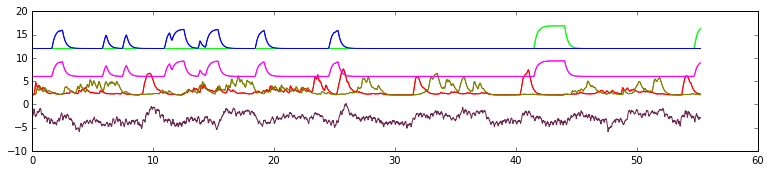

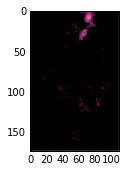

PB
IB_R
IB_L
6
DvGlutMARCM-F814_seg1
VGlut-F-400232
NO
PB
MB_PED_R
FB
15
DvGlutMARCM-F1153_seg1
VGlut-F-000312
NO
PB
IB_R
IB_L
16
TPHMARCM-1133M_seg2
Trh-M-100061
protocerebral bridge


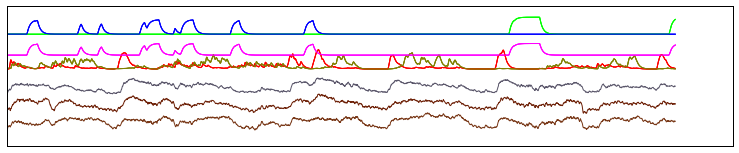

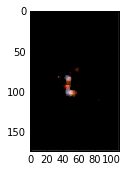

LH_R
SLP_R
SIP_R
2
DvGlutMARCM-F1730_seg1
VGlut-F-200319
lateral horn


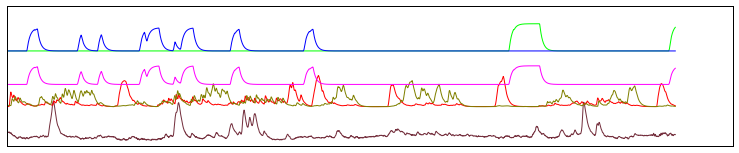

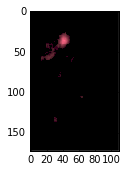

CAN_R
GNG
CAN_L
118
DvGlutMARCM-F1181_seg1
VGlut-F-200236
cantle


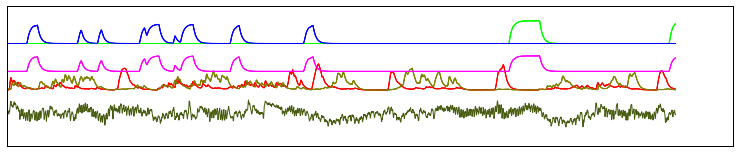

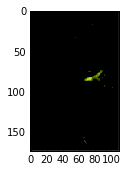

PB
ICL_R
IB_R
IB_L
56
TPHMARCM-071F_seg1
Trh-F-100028
ICL_R
PVLP_R
ICL_L
ATL_L
134
DvGlutMARCM-F694_seg1
VGlut-F-200144
inferior clamp


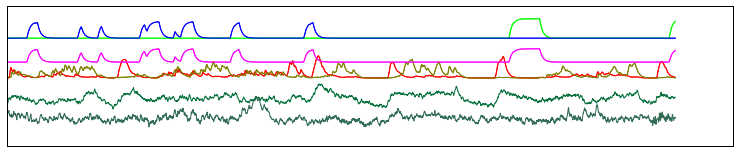

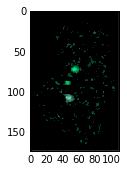

PB
ICL_R
ATL_R
ATL_L
9
GadMARCM-F000335_seg002
Gad1-F-400049
antler


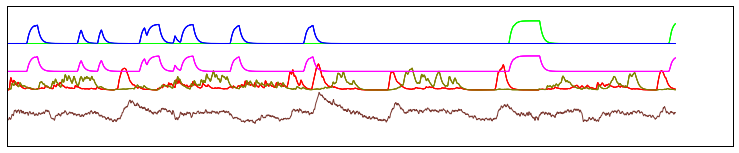

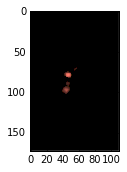

MB_PED_R
GOR_R
GNG
115
FruMARCM-F000495_seg001
fru-F-500028
pedunculus of adult mushroom body


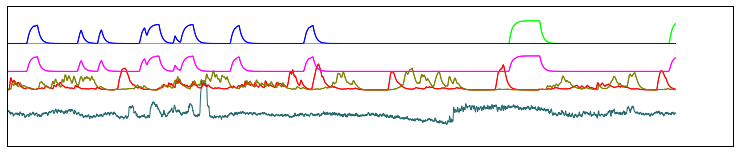

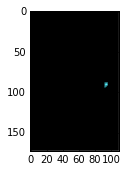

LO_R
LOP_R
ME_R
PVLP_R
152
TPHMARCM-1043M_seg1
Trh-M-900027
lobula plate


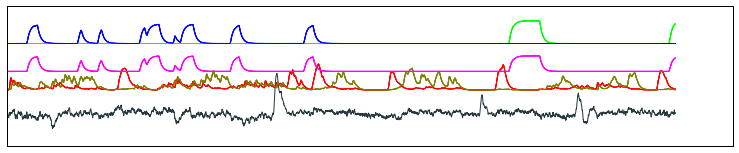

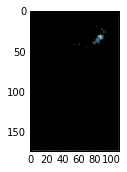

LO_R
CRE_R
ME_R
BU_L
48
DvGlutMARCM-F727_seg1
VGlut-F-400174
LOP_R
ME_R
69
TPHMARCM-M001687_seg001
Trh-M-600097
LOP_R
ME_R
98
TPHMARCM-1033M_seg1
Trh-M-700055
LOP_R
ME_R
123
TPHMARCM-1033M_seg1
Trh-M-700055
LOP_R
ME_R
GOR_L
126
TPHMARCM-041F_seg1
Trh-F-300000
LOP_R
ME_R
131
TPHMARCM-041F_seg1
Trh-F-300000
LOP_R
ME_R
166
TPHMARCM-041F_seg1
Trh-F-300000
medulla


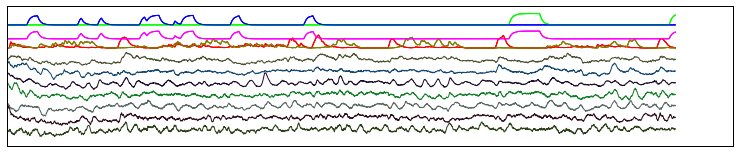

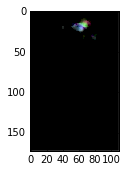

EB
FB
101
DvGlutMARCM-F362_seg1
VGlut-F-400074
EB
FB
SMP_R
145
DvGlutMARCM-F362_seg1
VGlut-F-400074
fan-shaped body


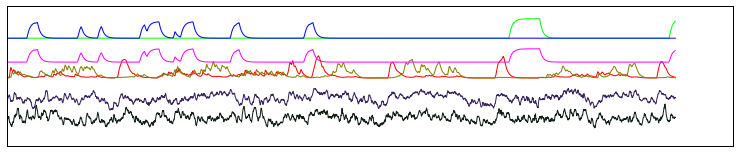

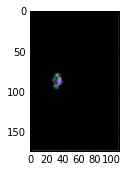

ATL_R
SMP_R
77
ChaMARCM-F001254_seg001
Cha-F-100245
superior medial protocerebrum


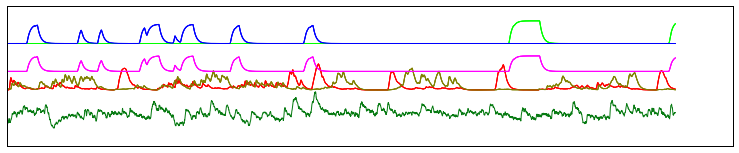

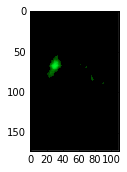

LH_R
PLP_R
MB_CA_R
SCL_R
44
THMARCM-328M_seg1
TH-M-200035
posterior lateral protocerebrum


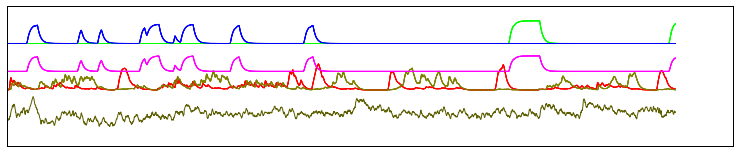

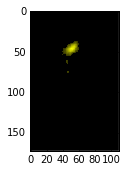

FLA_R
GNG
AMMC_L
22
THMARCM-234M_seg2
TH-M-000007
MB_PED_R
GNG
81
ChaMARCM-F000823_seg002
Cha-F-300235
LO_R
GNG
85
DvGlutMARCM-F1176_seg1
VGlut-F-000316
SAD
VES_R
GNG
88
THMARCM-234M_seg2
TH-M-000007
EPA_R
GNG
PRW
FLA_L
89
ChaMARCM-F000823_seg002
Cha-F-300235
SAD
GNG
PRW
GOR_L
97
DvGlutMARCM-F941_seg1
VGlut-F-200184
GNG
127
DvGlutMARCM-F868_seg1
VGlut-F-000207
GNG
144
THMARCM-234M_seg2
TH-M-000007
AOTU_R
GNG
153
THMARCM-234M_seg2
TH-M-000007
adult gnathal ganglion


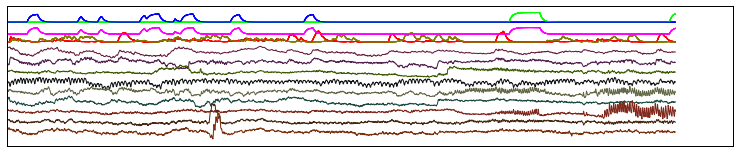

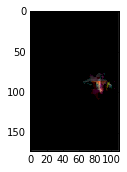

IVLP_R
LO_L
IVLP_L
PLP_L
25
DvGlutMARCM-F537_seg1
VGlut-F-000138
LO_L
LOP_L
ME_L
30
TPHMARCM-M001440_seg001
Trh-M-000036
LOP_R
LO_L
ME_L
91
DvGlutMARCM-F608_seg001
VGlut-F-300102
lobula


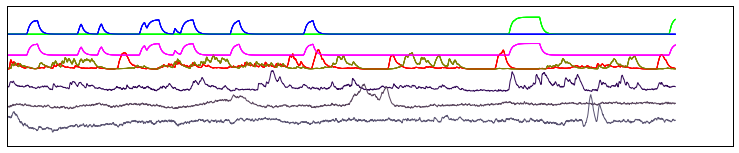

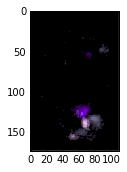

LH_L
SLP_L
SIP_L
1
ChaMARCM-F001138_seg001
Cha-F-100223
LH_R
LH_L
AMMC_L
PLP_L
18
DvGlutMARCM-F043-X3_seg2
VGlut-F-200021
lateral horn


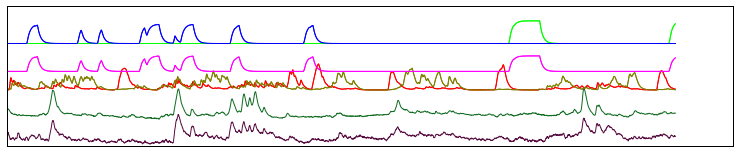

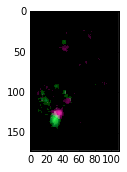

ATL_L
SLP_L
65
DvGlutMARCM-F047_seg1
VGlut-F-200026
antler


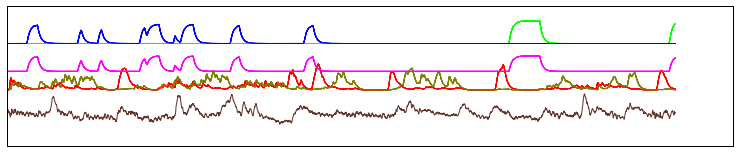

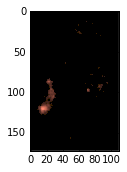

LO_L
LOP_L
14
DvGlutMARCM-F917_seg1
VGlut-F-200173
LO_L
LOP_L
43
FruMARCM-M000894_seg001
fru-M-500076
lobula plate


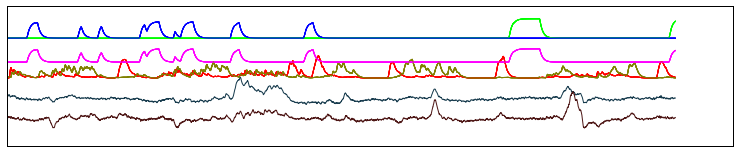

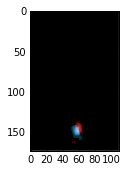

LO_L
LOP_L
ME_L
17
DvGlutMARCM-F649_seg1
VGlut-F-300110
LO_L
LOP_L
ME_L
21
TPHMARCM-M001440_seg001
Trh-M-000036
LO_L
LOP_L
ME_L
26
TPHMARCM-001F_seg1
Trh-F-100000
LOP_L
ME_L
37
TPHMARCM-001F_seg1
Trh-F-100000
CAN_R
LOP_L
ME_L
47
TPHMARCM-001F_seg1
Trh-F-100000
AOTU_R
LOP_L
ME_L
AVLP_L
63
DvGlutMARCM-F824_seg1
VGlut-F-000196
medulla


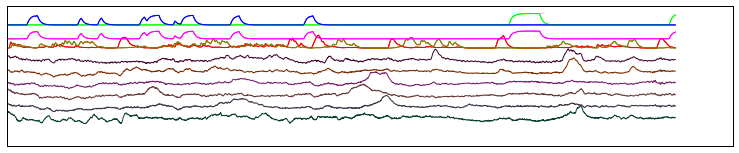

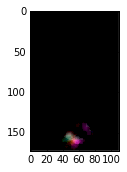

SAD
AMMC_L
AVLP_L
IVLP_L
13
TPHMARCM-M001802_seg001
Trh-M-000134
anterior ventrolateral protocerebrum


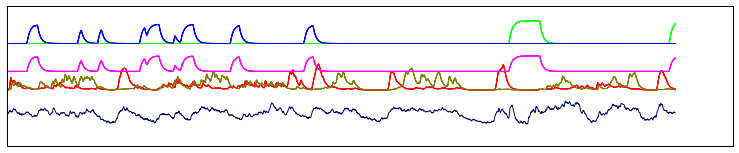

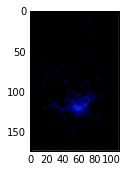

LH_L
PLP_L
38
DvGlutMARCM-F342_seg1
VGlut-F-100031
posterior lateral protocerebrum


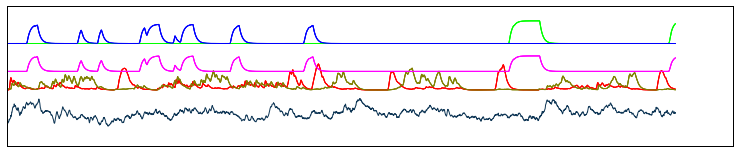

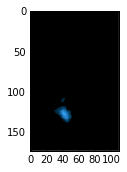

LAL_L
CRE_L
AL_L
MB_CA_L
42
DvGlutMARCM-F577_seg1
VGlut-F-000167
calyx of adult mushroom body


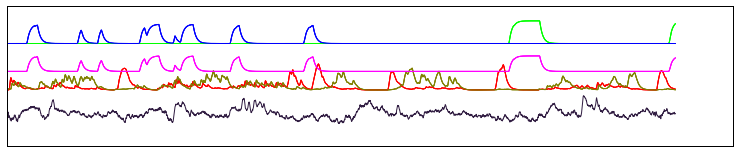

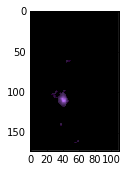

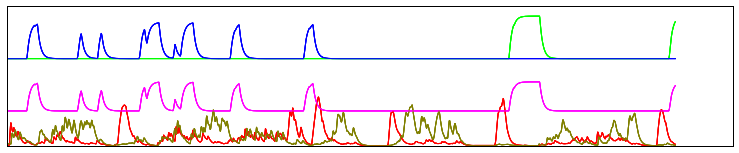

In [365]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(74):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)        
            tot=tot+1
            GoodICAnat[i]=1
            #print(i)
            for j in range(75):
                if CompNameAdd[i,j]==1:                
                    print(Names[np.array(j)][0])
            print(i)
            I=np.argmax(Scores[:,i])
            #print(I)
            print(e[0][I])
            print(NeuronName[np.int(np.float(e[3][I]))])
            
    plt.plot(Time_fluoICA.T,Xk[:,0]/np.std(Xk[:,0])+2,color=(1,0,0))   
    plt.plot(Time_fluoICA.T,Xk[:,1]/np.std(Xk[:,1])+2,color=(0.5,0.5,0))
    plt.plot(Time_fluoICA.T,Xk[:,4]/np.std(Xk[:,4])+6,color=(1,0,1))
    plt.plot(Time_fluoICA.T,Xk[:,6]/np.std(Xk[:,6])+12,color=(0,1,0))
    plt.plot(Time_fluoICA.T,Xk[:,7]/np.std(Xk[:,7])+12,color=(0,0,1))
    #plt.plot(Time_fluoICA.T,2*Xk[:,2]/np.max(Xk[:,2])+1.5,color=(1,0,1))    
    if n!=0:
        print(Names[l][1])

        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        
# Open template

In [32]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenamet = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenamet)
nimt=nb.load(filenamet)
Dtemp=np.squeeze(nimt.get_data())
Dtemp.shape

/media/sophie2/100160/100160it30/AVG_100160ss2cregcpsf.nii


(173, 110, 10)

# Reorder by larger sub-regions (~ presumed stimulus to motor)

In [33]:
LargerRegionsDic={'':'','AME_R':'OL','LO_R':'OL','NO':'CX','BU_R':'CX','PB':'CX','LH_R':'LH','LAL_R':'LX','SAD':'PENP'
               ,'CAN_R':'PENP','AMMC_R':'PENP','ICL_R':'INP','VES_R':'VMNP','IB_R':'INP','ATL_R':'INP','CRE_R':'INP'
               ,'MB_PED_R':'MB','MB_VL_R':'MB','MB_ML_R':'MB','FLA_R':'PENP','LOP_R':'OL','EB':'CX','AL_R':'AL',
                'ME_R':'OL','FB':'CX','SLP_R':'SNP','SIP_R':'SNP','SMP_R':'SNP','AVLP_R':'VLNP','PVLP_R':'VLNP',
                'IVLP_R':'VLNP','PLP_R':'VLNP','AOTU_R':'VLNP','GOR_R':'VMNP','MB_CA_R':'MB','SPS_R':'VMNP',
                'IPS_R':'VMNP','SCL_R':'INP','EPA_R':'VMNP','GNG':'GNG','PRW':'PENP','GA_R':'LX','AME_L':'OL'
                ,'LO_L':'OL','BU_L':'CX','LH_L':'LH','LAL_L':'LX','CAN_L':'PENP','AMMC_L':'PENP','ICL_L':'INP',
                'VES_L':'VMNP','IB_L':'INP','ATL_L':'INP','CRE_L':'INP','MB_PED_L':'MB','MB_VL_L':'MB',
                'MB_ML_L':'MB','FLA_L':'PENP','LOP_L':'OL','AL_L':'AL','ME_L':'OL','SLP_L':'SNP','SIP_L':'SNP',
                'SMP_L':'SNP','AVLP_L':'VLNP','PVLP_L':'VLNP','IVLP_L':'VLNP','PLP_L':'VLNP','AOTU_L':'VLNP',
                'GOR_L':'VMNP','MB_CA_L':'MB','SPS_L':'VMNP','IPS_L':'VMNP','SCL_L':'INP','EPA_L':'VMNP','GA_L':'LX'}

In [34]:
SmallRegionsSorted=['ME_L','ME_R','LO_R','LO_L','LOP_R','LOP_L','AME_R','AME_L',
                  'PLP_R','PLP_L','PVLP_R','PVLP_L','AVLP_R','AVLP_L','AOTU_R','AOTU_L','IVLP_R','IVLP_L',
                  'AL_R','AL_L',
                  'MB_CA_R','MB_CA_L','MB_PED_R','MB_PED_L','MB_VL_R','MB_VL_L','MB_ML_R','MB_ML_L',
                  'SMP_R','SMP_L','SIP_R','SLP_L','SLP_R','SIP_L',
                  'LH_R','LH_L',                  
                  'CRE_R','CRE_L','ICL_R','ICL_L','SCL_R','SCL_L','IB_R','IB_L','ATL_R','ATL_L',
                  'EB','PB','NO','FB',
                  'BU_R','BU_L','LAL_R','LAL_L','GA_R','GA_L',
                  'GOR_R','GOR_L','EPA_R','EPA_L','VES_R','VES_L','SPS_R','SPS_L','IPS_R','IPS_L',
                  'AMMC_R','AMMC_L','SAD','FLA_R','FLA_L','PRW','CAN_R','CAN_L',
                  'GNG','']

In [35]:
Tozip=range(len(SmallRegionsSorted))
SmallRegionsDic=dict(zip(SmallRegionsSorted,Tozip))

In [36]:
LargerRegion=[LargerRegionsDic[CompMainName[i]] for i in range(S[3])]

In [37]:
LargerRegionInd={ 'OL':1,'VLNP':2,'VMNP':3,'AL':4,'MB':5,'LH':6,'SNP':7,'CX':8,'LX':9,'INP':10,'PENP':11,'GNG':12,'':13}

In [38]:
LargerRegionI=np.array([LargerRegionInd[LargerRegion[i]] for i in range(S[3])])

In [39]:
SmallRegion=np.array([SmallRegionsDic[CompMainName[i]] for i in range(S[3])])

In [40]:
NewOrder=np.argsort(SmallRegion)

In [41]:
SmallRegion[NewOrder]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,
        7, 12, 13, 17, 17, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 25, 25, 25, 29, 30, 31, 33,
       34, 34, 34, 34, 35, 35, 37, 42, 42, 42, 43, 43, 44, 44, 44, 44, 44,
       44, 44, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 48, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 54,
       54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 60, 62, 62,
       62, 62, 64, 64, 65, 65, 66, 67, 67, 67, 67, 67, 69, 69, 71, 71, 71,
       71, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74,
       74, 74, 74, 74, 74, 74, 74, 74, 74])

# Last pruning by hand

In [42]:
%%javascript
IPython.OutputArea.auto_scroll_threshold =4000;

<IPython.core.display.Javascript object>

In [43]:
if S[2]>5:
    Nstack=5
    Int100=[(i+1)*100/Nstack for i in range(Nstack)]
    Percs=np.percentile(range(S[2]),Int100)
    Indices=np.split(range(S[2]),Percs)
    D1=np.zeros([S[0],S[1],Nstack])
    Dmean=np.squeeze(data[:,:,range(Nstack),2])
    for i in range(Nstack):
        Vmean=np.mean(Dtemp[:,:,Indices[i]],2)
        Dmean[:,:,i]=Vmean
else:
    Nstack=S[2]
    D1=np.zeros([S[0],S[1],S[2]])
    Dmean=data[:,:,range(S[2])]  
    Dmean=np.squeeze(Dtemp[:,:,:])

/usr/local/lib/python2.7/dist-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


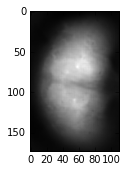

In [44]:
plt.imshow(Dmean[:,:,1],cmap=plt.cm.gray)

In [45]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)
Good_ICs=np.zeros(S[3])
Label_ICs=[]
pylab.rcParams['figure.figsize'] = (15, 2.5)

In [46]:
algorithm = linear_model.LinearRegression()

In [47]:
Sxk=Xk.shape

In [48]:
Sxk

(5527, 8)

In [51]:
X=np.zeros((5527, 6))

In [52]:
X[:,0]=(Xk[:,0]-np.mean(Xk[:,0]))/np.std(Xk[:,0])
X[:,1]=(Xk[:,1]-np.mean(Xk[:,1]))/np.std(Xk[:,1])
X[:,2]=(Xk[:,3]-np.mean(Xk[:,3]))/np.std(Xk[:,3])
X[:,3]=(Xk[:,4]-np.mean(Xk[:,4]))/np.std(Xk[:,4])
X[:,4]=(Xk[:,6]-np.mean(Xk[:,6]))/np.std(Xk[:,6])
X[:,5]=(Xk[:,7]-np.mean(Xk[:,7]))/np.std(Xk[:,7])

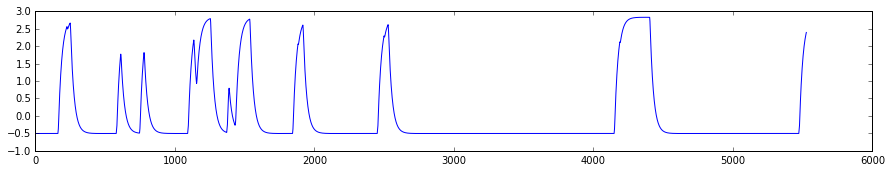

In [53]:
#plt.plot(X[:,0])
#plt.plot(X[:,1])
#plt.plot(X[:,2])
plt.plot(X[:,3])

In [54]:
Rsq=np.zeros((4,S[3]))
Betas=np.zeros((4,S[3]))

In [55]:
for j in range(S[3]):

    a=''
    if S[2]>5:
        for i in range(Nstack):
            V=Dmaps[:,:,Indices[i],j]
            D1[:,:,i]=np.max(V,2)
        D2[:,:,:,j]=D1
        D1[D1==0]=np.nan
           
    else:
        for i in range(S[2]):
            V=Dmaps[:,:,i,Order[j]]
            D1[:,:,i]=V 

    if (CompMainName[j] != '') and (LargerRegionI[j]!=1) and (LargerRegionI[j]==1 or LargerRegionI[j]==1
                                                             
                                                             
                                                             ):
        print(j)
        print(CompMainName[j])
        for i in range(Nstack):
            plt.subplot(1,5,i+1)
            plt.imshow(Dmean[:,:,i],cmap=plt.cm.gray)
            plt.imshow(D1[:,:,i], cmap=my_cmap,interpolation='none')
            frame1 = plt.gca()
            frame1.axes.get_xaxis().set_visible(False)
            frame1.axes.get_yaxis().set_visible(False)
        
        plt.show()
        
        model = algorithm.fit(X, DT[:,j])
        betas = model.coef_
        rsq = model.score(X,DT[:,j])
        print('left:',betas[0],'right:',betas[1],'walk:',betas[2],'groom:',betas[3])
        print(rsq)
        plt.plot(Time_fluoICA.T,2*DT[:,j]+1.5)
        plt.plot(Time_fluoICA.T,X[:,0],color=(1,0,0))   
        plt.plot(Time_fluoICA.T,X[:,1],color=(1,0,0))
        plt.show()
        a=raw_input()
    
    Label_ICs.append(a)
    if Label_ICs[j]!='':
        Good_ICs[j]=1

In [56]:
Dmaps.shape

(173, 110, 10, 179)

In [57]:
fn=open('/home/sophie/Desktop/100160GoodICs150.txt','w')
for i in range(S[3]):
    if Good_ICs[i]:
        print>>fn, i
        print>>fn, CompMainName[i]
        print>>fn, Good_ICs[i]

In [58]:
if len(Label_ICs)<S[3]:
    for j in range(S[3]-len(Label_ICs)):
      Label_ICs.append('')  

In [59]:
G=Good_ICs.tolist();

In [60]:
len(Good_ICs)

179

# Plot all components for turning left, right, walking, and grooming

In [61]:
Rsq=np.zeros((1,S[3]))
Betas=np.zeros((6,S[3]))
for j in range(S[3]):
    model = algorithm.fit(X, DT[:,j])
    Betas[:,j] = model.coef_
    Rsq[:,j] = model.score(X,DT[:,j])

In [62]:
RsqUni=np.zeros((6,S[3]))
BetaUni=np.zeros((6,S[3]))
Sx=X.shape
for k in range(6):
    for j in range(S[3]):
        model = algorithm.fit(np.reshape(X[:,k],(Sx[0],1)), DT[:,j])
        BetaUni[k,j] = model.coef_
        RsqUni[k,j] = model.score(np.reshape(X[:,k],(Sx[0],1)),DT[:,j])
    

In [63]:
RsqUni.shape

(6, 179)

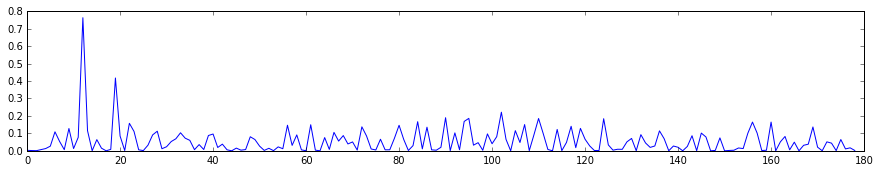

In [64]:
plt.plot(RsqUni[0,:])

In [65]:
GoodICo=Good_ICs[NewOrder]
D2o=D2[:,:,:,NewOrder]
LargerRegionIo=LargerRegionI[NewOrder]
Ind=np.array(range(S[3]))
Indexo=Ind[NewOrder]
DTo=DT[:,NewOrder]

In [66]:
import random

In [72]:
del Final_map
del Fmaps

In [83]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3]) 
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)
S1=DT.shape

In [84]:
random.uniform(0,1)

0.6546758991202721

In [86]:
C=np.zeros((S[3],3))
i=0
for j in range(S[3]):  
    if Betas[0,j]>0.85*np.max(Betas[0,:]):
    #if 1>0.1:
        #C[j,:]=C1[i%6][:]
        C[j,0]=1
        C[j,1]=random.uniform(0,1)
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.8*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        J=j
        #print(Indexo[j])
        i=i+1

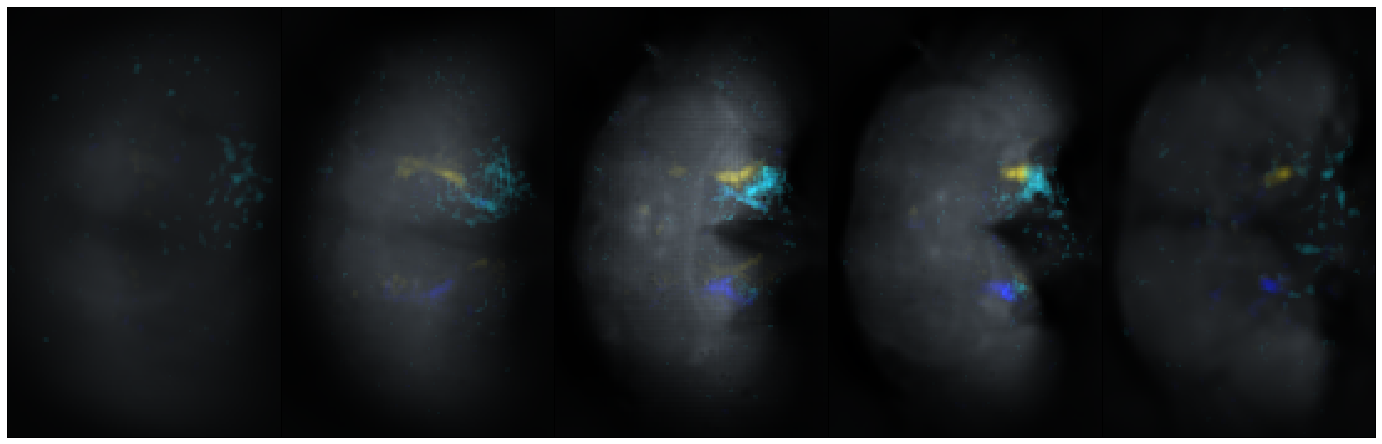

In [87]:
pylab.rcParams['figure.figsize'] = (19, 6)
C2=np.zeros(3)

Df=np.zeros([S[0],S[1],5,3]) 
  
for i in range(3):
    Df[:,:,:,i]=Final_map[:,:,:,i]+Dmean/16
    Df=Df/(np.max(np.max(Df)))
if S[2]>5:
    N=Nstack
else:
    N=S[2]
for i in range(N):
    #if Good_ICs[j]:
        plt.subplot(1,N,i+1)
        plt.imshow(Df[:,:,i],cmap=plt.cm.gray)
        plt.imshow(Df[:,:,i,:],cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

# Plot all components together

In [150]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3]) 
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])

In [151]:
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)
S1=DT.shape

In [152]:
GoodICo=Good_ICs[NewOrder]
D2o=D2[:,:,:,NewOrder]
LargerRegionIo=LargerRegionI[NewOrder]
Ind=np.array(range(S[3]))
Indexo=Ind[NewOrder]
DTo=DT[:,NewOrder]

In [153]:
C=np.zeros((S[3],3))
i=0
for j in range(S[3]):  
    if LargerRegionIo[j]<12 and GoodICo[j]:
        C[j,:]=C1[i%6][:]
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2o[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.6*D2o[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #print(Indexo[j])
        i=i+1

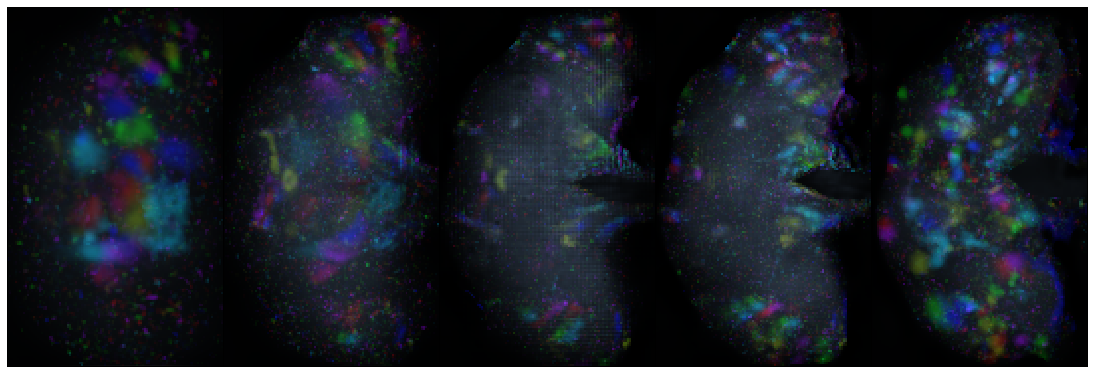

In [154]:
pylab.rcParams['figure.figsize'] = (15, 6)
C2=np.zeros(3)

Df=np.zeros([S[0],S[1],5,3]) 
  
for i in range(3):
    Df[:,:,:,i]=Final_map[:,:,:,i]+Dmean/16
    Df=Df/(np.max(np.max(Df)))
if S[2]>5:
    N=Nstack
else:
    N=S[2]
for i in range(N):
    #if Good_ICs[j]:
        plt.subplot(1,N,i+1)
        plt.imshow(Dmean[:,:,i],cmap=plt.cm.gray)
        plt.imshow(Df[:,:,i,:],cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

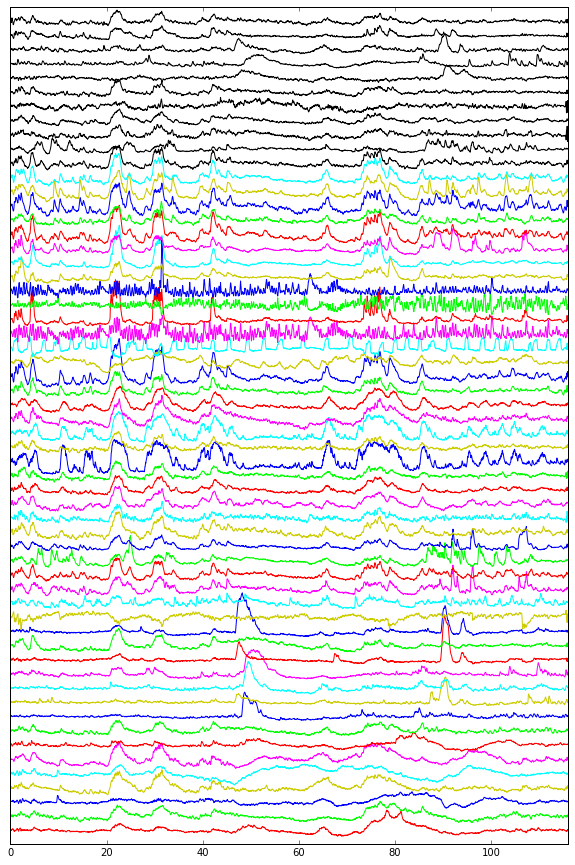

In [123]:
pylab.rcParams['figure.figsize'] = (10, 15)
h=0.5
i=0

for j in range(S[3]):
    if GoodICo[j]:
        plt.plot(Time_fluoICA,(DTo[:,j]+h*i),color=C[j,:]) 
        i=i+1
plt.xlim([np.min(Time_fluoICA),np.max(Time_fluoICA)])
plt.ylim([-0.5,h*i])
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
plt.show()

In [124]:
k=0
J=np.zeros(len(GoodICo[GoodICo==1]))
for j in range(len(GoodICo)):
    if GoodICo[j]:
        print(k)
        print([CompMainName[Indexo[j]]])
        J[k]=j
        k=k+1

0
['ME_L']
1
['ME_L']
2
['ME_L']
3
['ME_L']
4
['ME_L']
5
['ME_L']
6
['ME_R']
7
['ME_R']
8
['LO_R']
9
['LO_R']
10
['LO_R']
11
['LO_R']
12
['LO_L']
13
['LO_L']
14
['LO_L']
15
['LOP_L']
16
['AVLP_R']
17
['AVLP_L']
18
['IVLP_R']
19
['IVLP_R']
20
['IVLP_L']
21
['AL_L']
22
['MB_VL_R']
23
['SMP_R']
24
['EB']
25
['PB']
26
['PB']
27
['PB']
28
['PB']
29
['PB']
30
['PB']
31
['SPS_R']
32
['SPS_L']
33
['IPS_R']
34
['IPS_R']
35
['IPS_R']
36
['IPS_R']
37
['IPS_R']
38
['IPS_R']
39
['IPS_R']
40
['IPS_L']
41
['IPS_L']
42
['SAD']
43
['FLA_L']
44
['PRW']
45
['PRW']
46
['PRW']
47
['GNG']
48
['']
49
['']
50
['']
51
['']
52
['']
53
['']
54
['']
55
['']
56
['']
57
['']


In [125]:
Sets=[range(10),range(10,12),range(12,17),range(17,20),20,range(21,23),range(23,25),25]

In [126]:
pylab.rcParams['figure.figsize'] = (12, 6)

for i in range(len(Sets)):
    
    Final_map2=np.zeros([S[0],S[1],3]) 
    Fmaps2=np.zeros([S[0],S[1],3]) 
    Final_map3=np.zeros([S[0],S[1],5,3]) 
    Fmaps3=np.zeros([S[0],S[1],5,3])     
     
    if type(Sets[i])==list:
        for j in np.array(Sets[i]):
            C=np.zeros((S[3],3))
            C[j,:]=C1[j%6][:]
            
            for k in range(3):           
                M=np.max(np.squeeze(np.reshape(D2o[:,:,:,J[j]],S[0]*S[1]*5)))
                Fmaps2[:,:,k]=0.9*np.mean(D2o[:,:,:,J[j]],2)*C[j,k]/M
                M=np.max(np.squeeze(np.reshape(D2o[:,:,:,J[j]],S[0]*S[1],5)))
                Fmaps3[:,:,:,k]=0.9*D2o[:,:,:,J[j]]*C[j,k]/M                
            Final_map2=Final_map2+Fmaps2
            Final_map3=Final_map3+Fmaps3            
                
    else:
        j=Sets[i]
        C[j,:]=C1[j%6][:]
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2o[:,:,:,J[j]],S[0]*S[1]*5)))
            Fmaps2[:,:,k]=0.8*np.mean(D2o[:,:,:,J[j]],2)*C[j,k]/M
        Final_map2=Final_map2+Fmaps2
                
    Df=np.zeros([S[0],S[1],3]) 
  
    for l in range(3):
        Df[:,:,l]=Final_map2[:,:,l]+np.mean(Dmean,2)/16
    MM=np.max(np.max(Df))

    Rotated=ndimage.rotate(Df[:,:,:]/MM,-90)
    a=plt.imshow(Rotated,cmap=my_cmap,interpolation='none')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

    plt.show()
                                

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: total size of new array must be unchanged